In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader
from autoencoder import Autoencoder
from M1_util_train_test import load_model, train, test, AverageMeter
from util_model import my_loss
from exp_version import get_hp_from_version_code
import util_image

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


# Load data

In [2]:
# data loaders
zoomlevel = 'zoom15'
data_version = '1571'
sampling = 'stratified'
batch_size = 16
num_workers = 8
image_size = 224
im_norm = 1

train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, batch_size, 
         num_workers, 
         image_size, 
         data_version=data_version, 
         sampling=sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=int(im_norm),
         demo = 0)

28278 images in dataset
3142 images in dataset


# Load existing models

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

loss_func = 'mse'
latent_dim = '18432'
image_size = str(image_size)
model_run_date = '2208'
v1 = 'G'
v2 = '1'

model_path = glob.glob(model_dir+"SAE/SAE_"+zoomlevel+"_"+latent_dim+"_"+v1+"_"+v2+\
                       "_"+model_run_date+"_*.pt")
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)


/dreambig/qingyi/image_chicago/models/SAE/SAE_zoom15_18432_G_1_2208_335.pt loaded.


In [90]:
config = saved['config']

encoder = config['encoder']
decoder = config['decoder']

model = load_model('autoencoder','Autoencoder', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) + \
           sum([param.view(-1).size()[0] for param in decoder.parameters()])

print('n_params: {}'.format(n_params))

model_config = config['model_config']
run_config = config['run_config']
data_config = config['data_config']
optim_config = config['optim_config']

n_params: 31961862


In [91]:
model.load_state_dict(saved['model_state_dict']);

model = model.to(device)
model.eval();

In [92]:
criterion = my_loss


In [93]:
def save_reconstruction():

    for step, (image_list, data, _) in enumerate(test_loader):

        data = data.to(device)
        recon_imgs, out_demo = model(data)

        if int(im_norm) != 0:
            if int(im_norm) == 1:
                if zoomlevel == 'zoom13':
                    mean = [0.3733, 0.3991, 0.3711]
                    std = [0.2173, 0.2055, 0.2143]
                elif zoomlevel == 'zoom15':
                    mean = [0.3816, 0.4169, 0.3868]
                    std = [0.1960, 0.1848, 0.2052]

            elif int(im_norm) == 2:
                mean = [0.5,0.5,0.5]
                std = [0.5,0.5,0.5]

            data = util_image.inverse_transform(data, mean, std)
            recon_imgs = util_image.inverse_transform(recon_imgs, mean, std)

        plot_image = 1
        fig, ax = plt.subplots(1, 1, figsize=(2,2))
        ax.imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
        ax.axis('off')

        fig.savefig(out_dir+"SAE_recon/"+zoomlevel+"_"+latent_dim+"_"+v1+"_"+v2+\
                   "_"+model_run_date+"_"+str(plot_image)+".png")

        plot_image = 15
        fig, ax = plt.subplots(1, 1, figsize=(2,2))
        ax.imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
        ax.axis('off')

        fig.savefig(out_dir+"SAE_recon/"+zoomlevel+"_"+latent_dim+"_"+v1+"_"+v2+\
                   "_"+model_run_date+"_"+str(plot_image)+".png")

        break

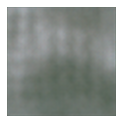

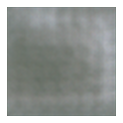

In [94]:
save_reconstruction()

In [95]:
def get_losses():
    loss_meter_1 = AverageMeter()
    loss_meter_2 = torch.zeros(10)
    
    for step, (image_list, data, demo) in enumerate(train_loader):

        demo = demo.to(device)
        data = data.to(device)

        recon_imgs, out_demo = model(data)

        loss1, loss2 = criterion(recon_imgs, out_demo, data, demo, return_components=True)

        loss_meter_2 += loss2
        
        num = data.size(0)

        loss_meter_1.update(loss1.item(), num)

#         if step % 10 == 0:
#             print(step, end='\t')

    best_1 = loss_meter_1.avg
    best_2 = loss_meter_2 / step
    
    loss_meter_1 = AverageMeter()
    loss_meter_2 = torch.zeros(10)

    for step, (image_list, data, demo) in enumerate(test_loader):

        demo = demo.to(device)
        data = data.to(device)

        recon_imgs, out_demo = model(data)

        loss1, loss2 = criterion(recon_imgs, out_demo, data, demo, return_components=True)

        loss_meter_2 += loss2

        num = data.size(0)

        loss_meter_1.update(loss1.item(), num)

    best_test_2 = loss_meter_2 / step

    best_test_1 = loss_meter_1.avg
    # best_test_2 = loss_meter_2.avg
    # print(best_test_1, best_test_2)         
    return best_1, best_2, best_test_1, best_test_2

In [96]:
recon_loss_train, demo_loss_train, recon_loss, demo_loss = get_losses()


In [97]:
with open(out_dir+"SAE_demo_loss.csv", "a") as f:
    f.write("%s,%s,%s,%s,%s,%s," %
            (model_run_date, zoomlevel, latent_dim, image_size, 
             v1, v2))
    f.write("%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f," % tuple(demo_loss_train.numpy()))
    f.write("%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % tuple(demo_loss.numpy()))


In [50]:
demo_mean = [0.03459964, 0.27158335, 0.44796609, 0.2635742 , 0.67193107, 0.3281, 
       0.15872199, 0.45013084, 0.61496312, 0.26206151]

In [2]:
demo_loss_df = pd.read_csv(out_dir+"SAE_demo_loss.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jtl/Dropbox (MIT)/project_image_demand/results/SAE_demo_loss.csv'

In [27]:
demo_vars = ['pop_density','pct25_34yrs','pct35_50yrs','pctover65yrs',
                 'pctwhite_alone','pct_nonwhite','pctblack_alone',
                 'pct_col_grad','avg_tt_to_work','inc_per_capita']

In [51]:
for v,m in zip(demo_vars, demo_mean):
    demo_loss_df['test_'+v] /= m
    demo_loss_df[v] /= m

In [7]:
cmap = plt.get_cmap('YlGnBu')

colors = cmap(np.linspace(0.25,0.75,5))


In [28]:
xlabels = ['pop density','pct25-34yrs','pct35-50yrs','pct over65yrs',
                 'pct white','pct non-white','pct black',
                 'pct col grad','avg tt to work','income']

In [15]:
demo_loss_df['recon_loss'] = [0.2798,0.278,0.439,0.5851,0.5151]
demo_loss_df['test_recon_loss'] = [0.2824,0.2836,0.4463,0.5856,0.5192]

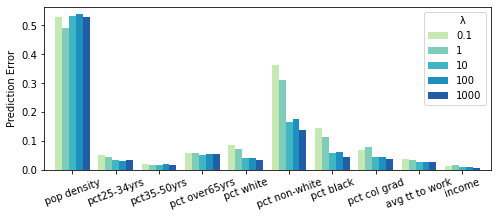

In [52]:
fig, ax = plt.subplots(figsize=(8,3))
demo_loss_df[['test_'+x for x in demo_vars]].set_index(pd.Index(['0.1','1','10','1000','100'])).sort_index().T.plot.bar(ax=ax, color=colors, width=0.8)
ax.legend(title='       \u03BB  ')
ax.set_ylabel("Prediction Error")
ax.set_xticklabels(xlabels, rotation=20);


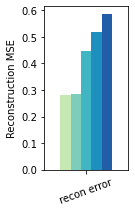

In [49]:
fig, ax = plt.subplots(figsize=(1.5,3))
demo_loss_df[['test_recon_loss']].set_index(pd.Index(['0.1','1','10','1000','100'])).sort_index().T.plot.bar(ax=ax, color=colors, width=0.8)
# ax.legend(title='       \u03BB  ')
ax.legend().set_visible(False)
ax.set_ylabel("Reconstruction MSE")
ax.set_xticklabels(['recon error'],rotation=20);


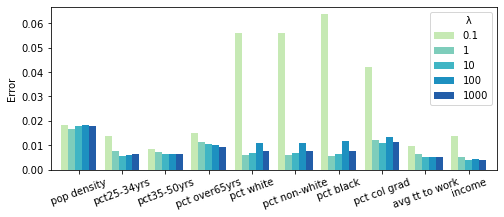

In [11]:
fig, ax = plt.subplots(figsize=(8,3))
demo_loss_df[demo_vars].set_index(pd.Index(['0.1','1','10','1000','100'])).sort_index().T.plot.bar(ax=ax, color=colors, width=0.8)
ax.legend(title='       \u03BB  ')
ax.set_ylabel("Error")
ax.set_xticklabels(xlabels, rotation=20);